In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import binom, multinomial, beta, dirichlet

plot_all_lines = False
import warnings
warnings.simplefilter('error', RuntimeWarning)


In [2]:
# Total sample size
N = 193
# True merger fraction
f_M = 0.4


# Realization of sample, where index 0 is isolated, 1 is a merger.
#true_gals = binom.rvs(1, f_M, size=N)
np.random.seed(0)
true_gals = np.random.choice([0,1], size=N, p=[1-f_M, f_M])
f_M_sample = true_gals.sum()/N

In [3]:
# Number of classifiers
n = 14
np.random.seed(0)
# Classifier accuracy at identifying mergers
r_Ms = np.random.uniform(low=0.5, high=0.8, size=n)
# Classifier accuracy at identifying isolated galaxies
r_Is = np.random.uniform(low=0.6, high=0.9, size=n)

In [4]:
# Matrix of classifier answers
m = np.zeros((n, N), dtype='int')
np.random.seed(0)
for i in range(n):
    for j in range(N):
        if true_gals[j] == 0:
            m[i,j] = np.random.choice([0,1], p=[r_Is[i], 1-r_Is[i]])
        elif true_gals[j] == 1:
            m[i,j] = np.random.choice([0,1], p=[1-r_Ms[i], r_Ms[i]])


Text(0, 0.5, '$\\mathrm{Isolated\\to Merger}$')

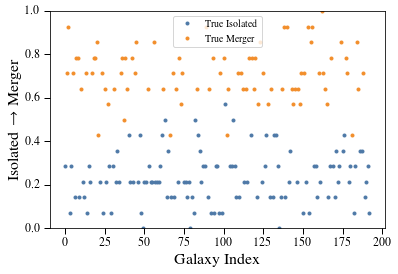

In [5]:
gal_inds = np.arange(N)
plt.plot(gal_inds[true_gals==0], m[:,true_gals==0].mean(axis=0), 'C0.', label='True Isolated')
plt.plot(gal_inds[true_gals==1], m[:,true_gals==1].mean(axis=0), 'C1.', label='True Merger')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('Galaxy Index')
plt.ylabel(r'$\mathrm{Isolated\to Merger}$')

(0, 193)

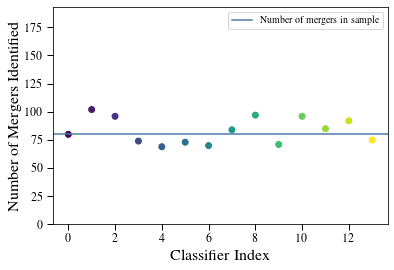

In [6]:
class_inds = np.arange(n)
N_M = m.sum(axis=1)
plt.scatter(class_inds, N_M, c=class_inds, cmap=plt.cm.viridis)
plt.axhline(sum(true_gals), label='Number of mergers in sample')
plt.xlabel('Classifier Index')
plt.ylabel('Number of Mergers Identified')
plt.legend(loc='best')
plt.ylim([0, N])

4.09878030638384
28.0


(0, 193)

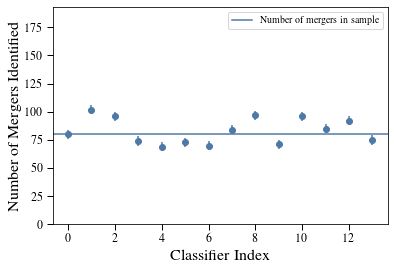

In [7]:
err = np.sqrt(f_M*(1-f_M)*70)
print(err)
print(70*f_M)
class_inds = np.arange(n)
plt.errorbar(class_inds, N_M, err, fmt='o')
plt.axhline(sum(true_gals), label='Number of mergers in sample')
plt.xlabel('Classifier Index')
plt.ylabel('Number of Mergers Identified')
plt.legend(loc='best')
plt.ylim([0, N])

(0.4, 0.7)

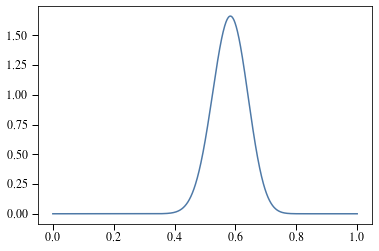

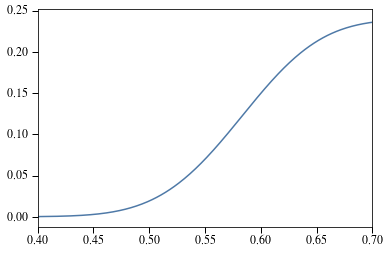

In [8]:
p = np.linspace(0, 1, 1000)
from scipy.special import gamma
def B(alpha, beta):
    return gamma(alpha)*gamma(beta)/gamma(alpha+beta)
alpha = 41 + 1
beta = 29 + 1
y = p**alpha*(1-p)**beta/B(alpha,beta)
plt.plot(p, y)

from scipy.integrate import cumtrapz

plt.figure()
plt.plot(p[1:], cumtrapz(y, p))
plt.xlim([0.4, 0.7])

(0, 1)

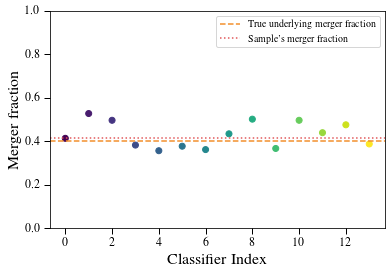

In [9]:
plt.scatter(class_inds, N_M/N, c=class_inds, cmap=plt.cm.viridis)
plt.axhline(f_M, label='True underlying merger fraction', color='C1', linestyle='--')
plt.axhline(f_M_sample, label="Sample's merger fraction", color='C2', linestyle=':')
plt.xlabel('Classifier Index')
plt.ylabel('Merger fraction')
plt.legend(loc='best')
plt.ylim([0,1])

Everything above was simulating the data. From here on out we will evaluate the likelihoods.

In [10]:
from scipy.special import binom, loggamma
def logbinom(n, k):
    return loggamma(n+1) - loggamma(k+1) - loggamma(n-k+1)

def logbinom_lnnk(n,k):
    logbinom = k*np.log(n/k - 0.5) + k -0.5*np.log(2*np.pi*k)
    return logbinom
    
def f_b(k, n, p, thresh=100):
    # k is an integer, n is an array
    logf1 = logbinom(n, k)


    logf2 = k*np.log(p)
    logf3 = (n-k)*np.log(1-p)
    logf_b = logf1+logf2+logf3
    return logf_b


def L(Ns, rj, rjp, N_M, Ntot, high_acc=False):
    L = 0
    if high_acc:
        N_Mks = np.linspace(0,N_M,1000)
    else:
        Ns = Ns.astype(int)
        N_Mks = np.arange(N_M+1)
    for k in range(len(N_Mks)):
        L1 = np.zeros(len(Ns))-np.inf
        L2 = np.zeros(len(Ns))-np.inf
        inds = ((Ns >= k) & (Ntot-Ns >= N_M-k))
        L1[inds] = f_b(k, Ns[inds], rj)
        L2[inds] = f_b(N_M-k, Ntot-Ns[inds], 1-rjp)
        L += np.exp(L1+L2)
    return L

In [11]:
Ns = np.linspace(0, N, 10*N)
if plot_all_lines:
    for i in range(n):
        plt.plot(Ns, L(Ns, r_Ms[i], r_Is[i], N_M[i], N), color=plt.cm.viridis(i/n))
    plt.xlabel(r'Estimated true underlying mergers $N_M$')
    plt.axvline(true_gals.sum(), label='True underlying number of galaxies', color='C1', linestyle='--')
    plt.xlim([0, N])

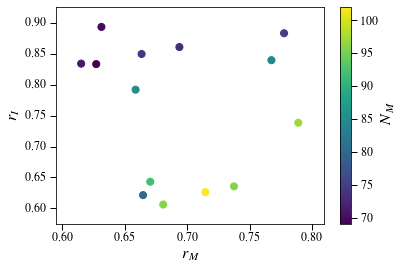

In [12]:
plt.scatter(r_Ms, r_Is, c=N_M, s=50)
plt.xlabel(r'$r_M$')
plt.ylabel(r'$r_I$')
plt.colorbar(label=r'$N_M$')

(60.822371448485406, 105.46334283722888)

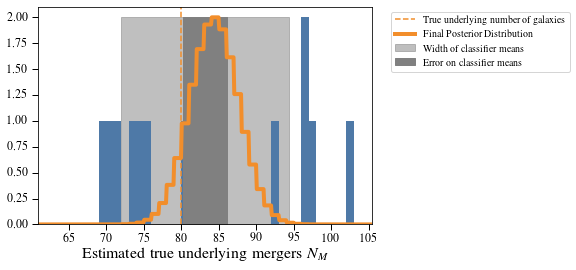

In [13]:
plt.figure()
lnLi = L(Ns, r_Ms[i], r_Is[i], N_M[i], N)*0

for i in range(n):
    lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
nbins, bins, patches = plt.hist(N_M, bins=np.arange(0, N), label='', zorder=-1.5)
plt.axvline(true_gals.sum(), label='True underlying number of galaxies', color='C1', linestyle='--')
plt.plot(Ns, nbins.max()*np.exp(lnLi-lnLi.max()),  label='Final Posterior Distribution', lw=4)
plt.fill_betweenx([0,nbins.max()], N_M.mean()-N_M.std(), N_M.mean()+N_M.std(), alpha=0.5, 
                  color='gray', label=r'Width of classifier means', zorder=-2)
plt.fill_betweenx([0,nbins.max()], N_M.mean()-2*np.sqrt(f_M*(1-f_M))*N_M.std()/len(N_M)**0.5, N_M.mean()+2*np.sqrt(f_M*(1-f_M))*N_M.std()/len(N_M)**0.5, alpha=1, 
                  color='gray', label=r'Error on classifier means', zorder=-1)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel(r'Estimated true underlying mergers $N_M$')
plt.xlim([N_M.mean()-2*N_M.std(), N_M.mean()+2*N_M.std()])

# How often is the "wrong way" off compared to the "right way"?

You can find abs(N-N_hat)/sigma_N for each distribution and plot the distribution of it.

# Likelihood for merger fraction

In [14]:
f_Ms = np.linspace(0, 1, 1000)
if plot_all_lines:
    for i in range(n):
        plt.plot(f_Ms, L(f_Ms*N, r_Ms[i], r_Is[i], N_M[i], N), color=plt.cm.viridis(i/n))
    plt.axvline(f_M, label='True underlying merger fraction', color='C1', linestyle='--')
    plt.axvline(f_M_sample, label="Sample's merger fraction", color='C2', linestyle=':')
    plt.legend(loc='best')
    plt.xlabel('Merger fraction')
    plt.xlim([0,1])

(0.3151418209766083, 0.5464421908664708)

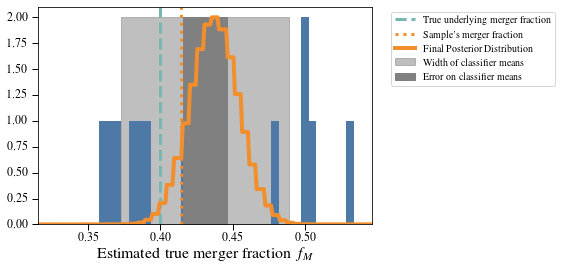

In [15]:
plt.figure()
lnLi = L(f_Ms, r_Ms[i], r_Is[i], N_M[i], N)*0

for i in range(n):
    lnLi += np.log(L(f_Ms*N, r_Ms[i], r_Is[i], N_M[i], N))
ylim = plt.gca().get_ylim(),
plt.axvline(f_M, label='True underlying merger fraction', color='C3', linestyle='--', lw=3)
plt.axvline(f_M_sample, label="Sample's merger fraction", color='C1', linestyle=':', lw=3)
n_binned, bins, patches = plt.hist(N_M/N, bins=np.arange(0,N)/N, label='', density=False, zorder=-1.5)
plt.plot(f_Ms, n_binned.max()*np.exp(lnLi-lnLi.max()),  label='Final Posterior Distribution', lw=4)
plt.fill_betweenx([0,n_binned.max()], (N_M.mean()-N_M.std())/N, (N_M.mean()+N_M.std())/N, alpha=0.5, 
                  color='gray', label=r'Width of classifier means', zorder=-2)
plt.fill_betweenx([0,n_binned.max()], (N_M.mean()-N_M.std()/len(N_M)**0.5)/N, (N_M.mean()+N_M.std()/len(N_M)**0.5)/N, alpha=1, 
                  color='gray', label=r'Error on classifier means', zorder=-1)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel(r'Estimated true merger fraction $f_M$')
plt.xlim((N_M.mean()-2*N_M.std())/N, (N_M.mean()+2*N_M.std())/N)

# What is the probability of any individual galaxy being in a merger?

(14,)


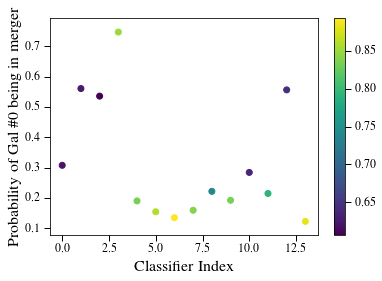

In [16]:
# Actual state of galaxy
ind = 0
G = true_gals[ind]
# Vector of guesses
Ghat = m[:,ind]
print(Ghat.shape)

# We will assume a prior of the true input value.
P_G = np.zeros(n)
for i in range(n):
    den = f_M*r_Ms[i] + (1-f_M)*(1-r_Is[i])
    if m[i,ind] == 0:
        P_G[i] = f_M*(1-r_Is[i])/den
    else:
        P_G[i] = f_M*r_Ms[i]/den
plt.scatter(class_inds, P_G, c=r_Is)
plt.xlabel('Classifier Index')
plt.ylabel(r'Probability of Gal \#0 being in merger')
plt.colorbar()

(14,)


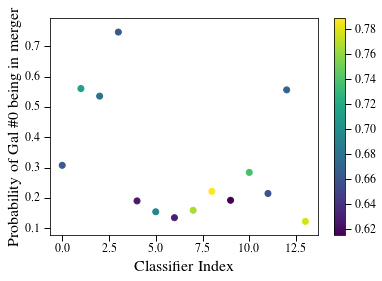

In [17]:
# Actual state of galaxy
ind = 0
G = true_gals[ind]
# Vector of guesses
Ghat = m[:,ind]
print(Ghat.shape)

# We will assume a prior of the true input value.
P_G = np.zeros(n)
for i in range(n):
    den = f_M*r_Ms[i] + (1-f_M)*(1-r_Is[i])
    if m[i,ind] == 0:
        P_G[i] = f_M*(1-r_Is[i])/den
    else:
        P_G[i] = f_M*r_Ms[i]/den
plt.scatter(class_inds, P_G, c=r_Ms)
plt.xlabel('Classifier Index')
plt.ylabel(r'Probability of Gal \#0 being in merger')
plt.colorbar()

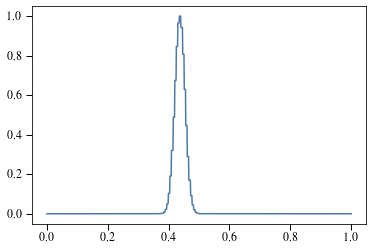

In [30]:
plt.plot(p, np.exp(lnLi-max(lnLi)))

P_fM = np.exp(lnLi - max(lnLi))

In [19]:
# Prior probability
P_M = f_M
P_I = 1-f_M
P_M = np.ones_like(p)
P_I = np.ones_like(p)
for p, f_M in zip(P_fM, p):
    # Update prior with each individual's answers
    for i in range(n):
        den = f_M*r_Ms[i] + (1-f_M)*(1-r_Is[i])
        if m[i,ind] == 0:
            P_M *= (1-r_Is[i])/den
        else:
            P_M *= r_Ms[i]/den
        if m[i,ind] == 0:
            P_I *= r_Is[i]/den
        else:
            P_I *= (1-r_Ms[i])/den

print(P_M/(P_M+P_I), P_I/(P_M+P_I))
print(G)

8.933263366653216e-06 0.9999910667366333
0


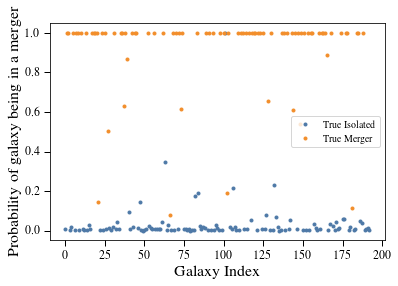

In [20]:
logP_M = np.ones(N)*f_M
logP_I = np.ones(N)*(1-f_M)

for ind in range(N):
    den = 0
    for i in range(n):
        if m[i,ind] == 0:
            logP_M[ind] += (1-r_Is[i])
            logP_I[ind] += r_Is[i]
        else:
            logP_M[ind] += r_Ms[i]
            logP_I[ind] += (1-r_Ms[i])
        den += f_M*r_Ms[i] + (1-f_M)*(1-r_Is[i])
    norm = max(logP_M[ind].max(), logP_I[ind].max())
    logP_M[ind] -= norm
    logP_I[ind] -= norm
P_M = np.exp(logP_M)
plt.plot(gal_inds[true_gals==0], P_M[true_gals==0], '.', label='True Isolated')
plt.plot(gal_inds[true_gals==1], P_M[true_gals==1], '.', label='True Merger')
plt.xlabel('Galaxy Index')
plt.ylabel('Probability of galaxy being in a merger')
plt.legend(loc='best')

# Multiple Classifiers

The analysis up until now assumed that galaxies were either mergers or not. I'll now extend this to multinomial distributions

### Potential difficulty
The mixing matrix $r_{ij}$ may be hard to estimate.

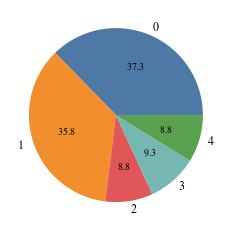

In [21]:
fracs_true = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
np.random.seed(0)
N_true = np.random.choice(np.arange(5), p=fracs_true, size=N)
labels = np.arange(5)
labels, sizes = np.unique(N_true, return_counts=True)
_=plt.pie(sizes, labels=labels, autopct='%1.1f%%')

In [22]:
r_ijks = np.zeros((n, 5, 5))
p_correct = 0.9
p_incorrect = (1-p_correct)/4
for i in range(n):
    for j in range(5):
        alphas = np.ones(5)*p_incorrect
        alphas[j] = p_correct
        r_ijks[i,j] = dirichlet.rvs(alphas)

In [23]:
m_ijs = np.zeros((n, N), dtype='int')
np.random.seed(1)
for i in range(n):
    for j in range(N):
        m_ijs[i,j] = np.random.choice(np.arange(5), p=r_ijks[i, N_true[j]])

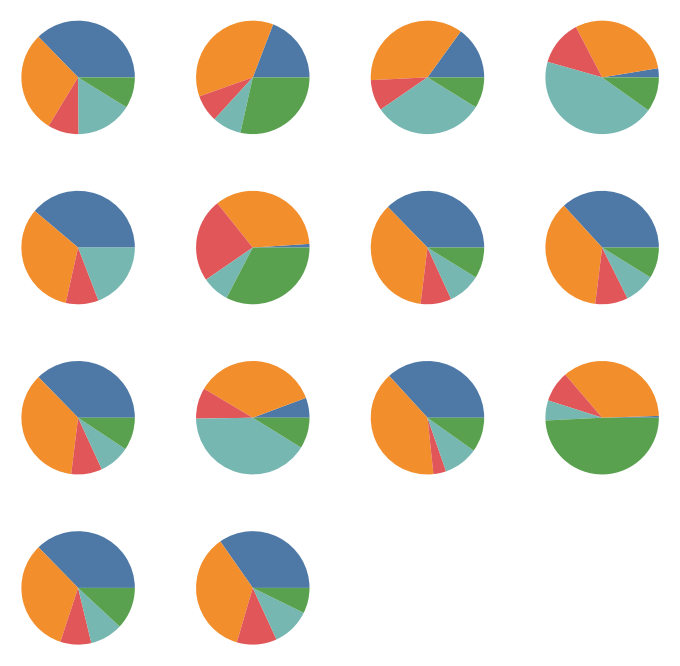

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axs = axes.flatten()
for i in range(len(axs)):
    if i < n:
        labels, sizes = np.unique(m_ijs[i], return_counts=True)
        axs[i].pie(sizes)
    else:
        axs[i].set_visible(False)

# Estimating what category each galaxy is in

I believe this involves just normalizing the binary case with all of the relevant probability outcomes.

Galaxy 0 is actually type 1


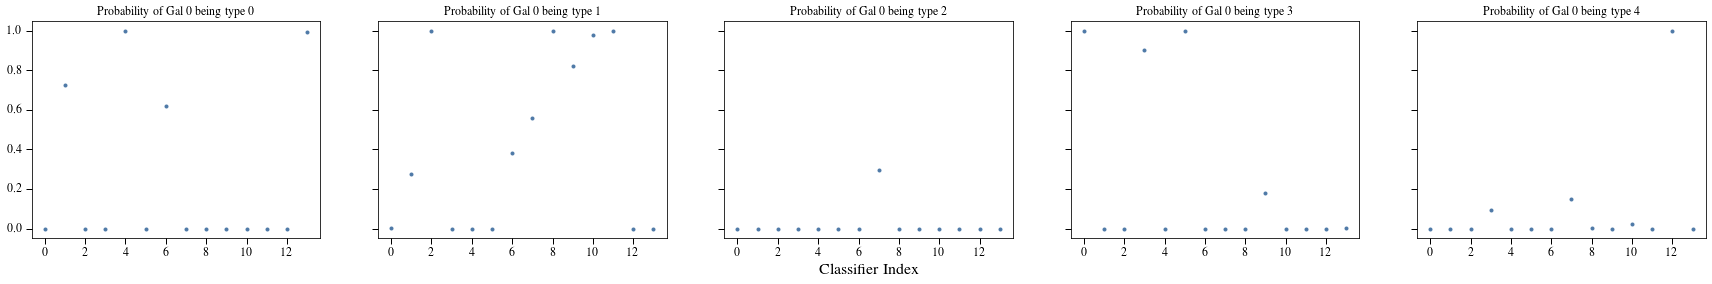

In [25]:
# Actual state of galaxy
ind = 0
G = N_true[ind]

# We will assume f_M is the true input value.
fig, axes = plt.subplots(ncols=5, figsize=(30, 4), sharey=True)
Ps = []
for gal_type in range(5):
    P = np.zeros(n)
    for i in range(n):
        num = fracs_true[gal_type]*r_ijks[i,m_ijs[i,gal_type],gal_type]
        den = 0
        for k in range(5):
            den += fracs_true[k]*r_ijks[i,m_ijs[i,k],k]
        P[i] = num/den
    axes[gal_type].plot(class_inds, P, '.')
    if gal_type == 2:
        axes[2].set_xlabel('Classifier Index')
    axes[gal_type].set_title(f'Probability of Gal {ind} being type {gal_type}')
    Ps.append(P)
    
print(f'Galaxy {ind} is actually type {G}')

In [26]:
gal_probs = np.zeros((N, 5))
for ind in range(N):
    # We will assume f_M is the true input value.
    logPs = np.zeros(5)
    for gal_type in range(5):
        nums = np.zeros(n)
        for i in range(n):
            nums[i] = r_ijks[i,m_ijs[i,ind],gal_type]
        logPs[gal_type] = np.log(fracs_true[gal_type]) + np.log(nums).sum()
    Ps = np.exp(logPs-logPs.max())
    gal_probs[ind] = Ps/Ps.sum()

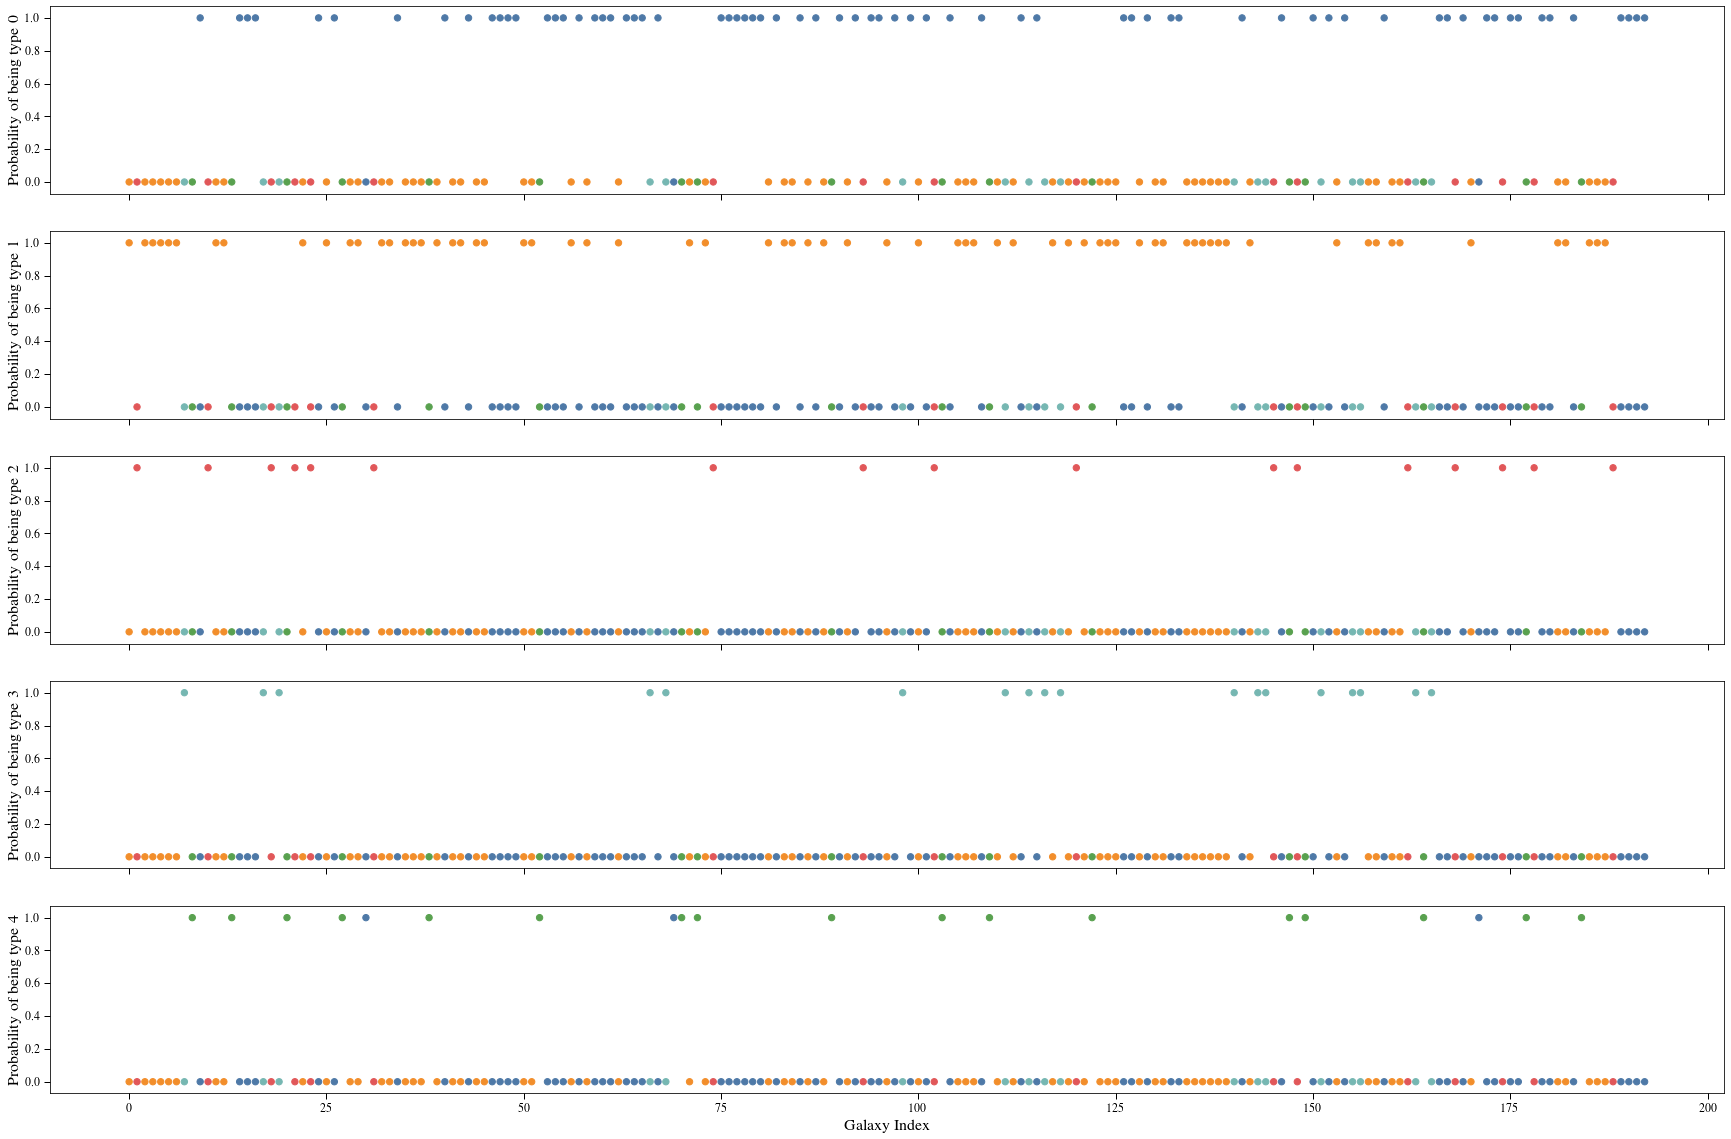

In [27]:
fig, axes = plt.subplots(nrows=5, figsize=(30, 20), sharey=True, sharex=True)
for i in range(5):
    axes[i].scatter(gal_inds, gal_probs[:,i], s=40, c=[f'C{i}' for i in N_true])
    if i == 4:
        axes[i].set_xlabel('Galaxy Index')
    axes[i].set_ylabel(f'Probability of being type {i}')

Text(0.5, 1.0, 'Estimated fractions')

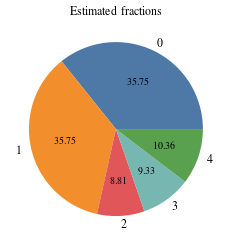

In [28]:
sizes_est = gal_probs.sum(axis=0)
_=plt.pie(sizes_est, labels=labels, autopct='%1.2f%%')
plt.title("Estimated fractions")

Text(0.5, 1.0, 'True fractions')

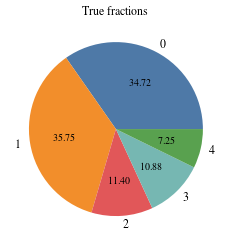

In [29]:
_=plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title("True fractions")